# Homework 3
### Daniela del Rio

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import scipy
from statistics import stdev
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

# Part 1

In [2]:
SpikeWaveforms = np.load('SpikeWaveforms.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))
# AP detected, time, electrode

(33787, 40, 4)


In [3]:
indices = []
Peaks_1 = []
Peaks_2 = []
Peaks_3 = []
Peaks_4 = []
xn_ex2 = []

# Indices for starting and ending
start = 5
end = 25

for i in range(33787): #33787
    
    average_tetrodes = np.zeros(40)

    for time_i in range(40):
        average_tetrodes[time_i] = (np.sum(SpikeWaveforms[i,time_i,0]+SpikeWaveforms[i,time_i,1]+SpikeWaveforms[i,time_i,2]+SpikeWaveforms[i,time_i,3]))/4
        
    index = np.argmax(average_tetrodes[start:end])
    
    Peaks_1.append(SpikeWaveforms[i, index, 0])
    Peaks_2.append(SpikeWaveforms[i, index, 1])
    Peaks_3.append(SpikeWaveforms[i, index, 2])
    Peaks_4.append(SpikeWaveforms[i, index, 3])
    xn_ex2.append(SpikeWaveforms[i, :, 0])

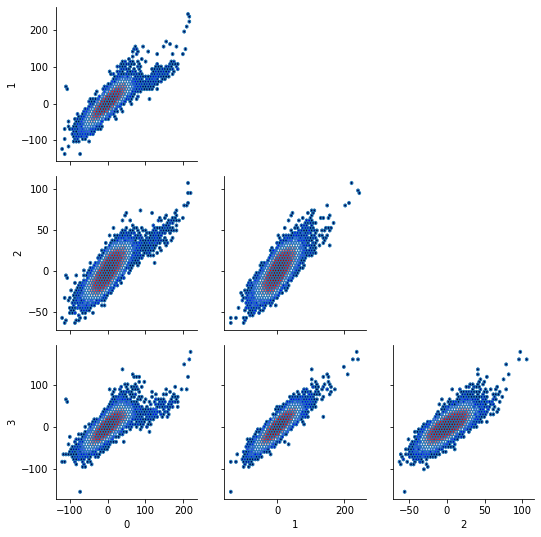

In [4]:
Peaks = [Peaks_1, Peaks_2, Peaks_3, Peaks_4]
Peaks = np.transpose(Peaks)

# Code from class website
PP = pd.DataFrame(np.array(Peaks))
g = sns.PairGrid(PP)
g = g.map_lower(plt.hexbin,gridsize=50, mincnt=1, cmap='seismic',bins='log')
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

# Part 2
## Clustering with K-means

In [5]:
def iterative_cost_function(xns, mk, rnks): # Cost function for 1 cluster
    n = len(xns)
    J = 0
    for i in range(n):
        if rnks[i]: 
            J += np.sum((xns[i]-mk)**2) #Sums all 40 values
    return J

def all_clusters_cost_function(xns, mks, rnks): # Cost function for all clusters
    J = 0
    
    for cluster_i in range(len(mks)):
        J+= iterative_cost_function(xns, mks[cluster_i], rnks[cluster_i])
    return J

In [6]:
# Assigning a cluster based on distance between centroids and points:
def distances(xns, mks):
    number_of_clusters = len(mks) #2000
    number_of_datapoints = len(xns) #3
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((xns[i]-mks[cluster_i])**2)
            
        minimum = np.argmin(distance)
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
    return rnks_1, rnks_2, rnks_3

In [7]:
def plot_traces(xns, rnks_1, rnks_2, rnks_3, mks):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))
    fig.suptitle('Neuron traces based on cluster', fontsize=20)

    time = [i for i in range(40)]
    for i in range(2000):

        if rnks_1[i]:
            ax1.plot(time, xns[i], color="salmon")

        elif rnks_2[i]:
            ax2.plot(time, xns[i], color="deeppink")

        elif rnks_3[i]:
            ax3.plot(time, xns[i], color="dimgrey")

    ax1.plot(time, mks[0], c="r")
    ax2.plot(time, mks[1], c="purple")
    ax3.plot(time, mks[2], c="k")
    plt.xlabel('Time')
    plt.ylabel("Voltage")
    plt.show()
    return None

In [8]:
# Updating centroids
def updates_centroids(xns, rnks_1, rnks_2, rnks_3):
    c1 = []
    c2 = []
    c3 = []

    for i in range(2000):

        if rnks_1[i]:
            c1.append(xns[i])

        elif rnks_2[i]:
            c2.append(xns[i])

        elif rnks_3[i]:
            c3.append(xns[i])

    mks1 = np.mean(c1, 0)
    mks2 = np.mean(c2, 0)
    mks3 = np.mean(c3, 0)
    
    return mks1, mks2, mks3 

In [9]:
def one_iteration(xns, mks_init):
    rnks_1, rnks_2, rnks_3 = distances(xns, mks_init)
    mks1, mks2, mks3 = updates_centroids(xns, rnks_1, rnks_2, rnks_3)
    
    mks = [mks1, mks2, mks3]
    rnks = [rnks_1, rnks_2, rnks_3]
    
    J = all_clusters_cost_function(xns, mks, rnks)
    return J, rnks, mks

The k-means algorithm stops running when the cost function stops changing, at least when the difference between the last and before last J values change less than $0.001 = 0.1 \%$ of the last J value. Notice this would present a problem if we had a values that kept changing periodically from one cluster to another. 

In [10]:
xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Initializes with 3 random traces from the dataset
mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
J = []
i = 0
converging = False

J1, rnks_1, mks = one_iteration(xns, mks_init) # First iteration
J.append(J1)

while converging == False:
    J1, rnks, mks = one_iteration(xns, mks)
    J.append(J1)
    
    if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
        print("Converging value occurs in the ", i+1, "th iteration.")
        converging = True
    i +=1

Converging value occurs in the  8 th iteration.


### Part a

First clusters


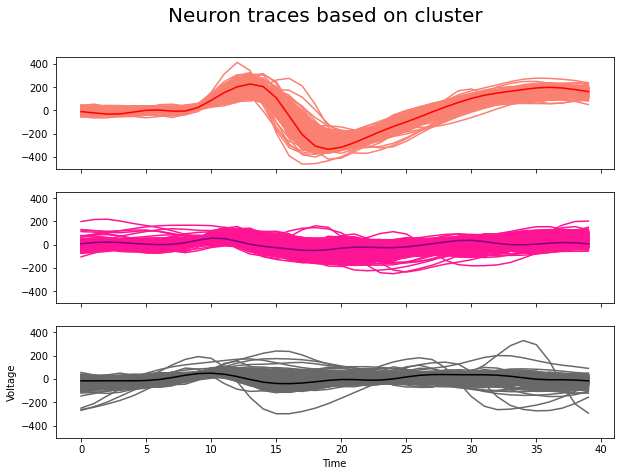

Last clusters


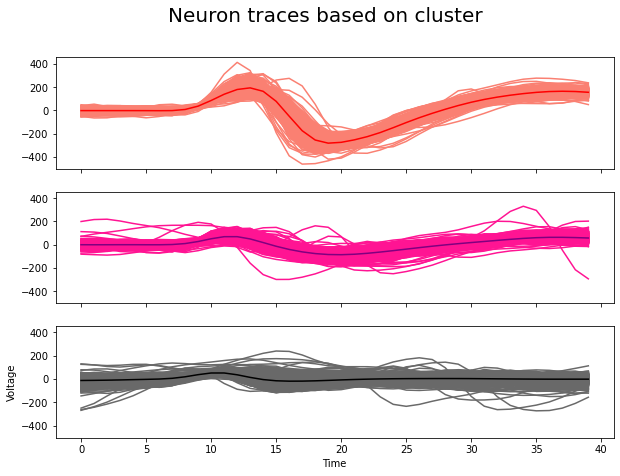

In [11]:
print("First clusters")
plot_traces(xns, rnks_1[0], rnks_1[1], rnks_1[2], mks_init)

print("Last clusters")
plot_traces(xns, rnks[0], rnks[1], rnks[2], mks)

### Part b

Notice in the following plot a horizontal line which corresponds to the last value of J (the converging J value). If we simply discriminate by eye, this convergence is generally reached in iterations 5 to 8. Nevertheless, see the following cells.

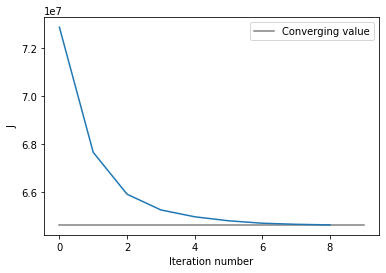

In [12]:
max_ind = len(J)
plt.plot([0,max_ind], [J[max_ind-1], J[max_ind-1]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

In [13]:
# Code for finding when the convergence occurs
# We will define convergence as the value when the difference between 2 iterations is less than 0.001
# of the last iteration value

converging_values = np.zeros(20)

xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Running the simulation 20 times,
for simulation_i in range(20):
    # Initializes with 3 random traces from the dataset
    mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
    J = []
    i = 0
    converging = False

    J1, rnks_1, mks = one_iteration(xns, mks_init) # First iteration
    J.append(J1)
    
    while converging == False:
        J1, rnks, mks = one_iteration(xns, mks)
        J.append(J1)

        if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
            converging_values[simulation_i] = i+1
            converging = True
        i +=1
        
print(converging_values)
print(np.mean(converging_values))

[14.  8.  5.  7.  4.  8.  7.  5.  7. 13.  7.  3.  7.  9. 15.  8.  8.  7.
  8.  4.]
7.7


In the previuos cell we iterated the K-means algorithm several times and found that the mean convergence time of the algorithm with $K=3$ is around 7 iterations.

### Part c
Using 4 clusters.

In [14]:
# Assigning a cluster based on distance between centroids and points:
def distances_4(xns, mks):
    number_of_clusters = len(mks) #2000
    number_of_datapoints = len(xns) #3
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_4 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((xns[i]-mks[cluster_i])**2)
            
        minimum = np.argmin(distance)
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
        elif minimum ==3: # Belongs in cluster 3
            rnks_4[i] = 1
    return rnks_1, rnks_2, rnks_3, rnks_4

def plot_traces_4(xns, rnks_1, rnks_2, rnks_3, rnks_4, mks):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True, figsize=(10,7))
    fig.suptitle('Neuron traces based on cluster', fontsize=20)

    time = [i for i in range(40)]
    for i in range(2000):

        if rnks_1[i]:
            ax1.plot(time, xns[i], color="salmon")

        elif rnks_2[i]:
            ax2.plot(time, xns[i], color="deeppink")

        elif rnks_3[i]:
            ax3.plot(time, xns[i], color="dimgrey")

        elif rnks_4[i]:
            ax4.plot(time, xns[i], color="lightblue")

    ax1.plot(time, mks[0], c="r")
    ax2.plot(time, mks[1], c="purple")
    ax3.plot(time, mks[2], c="k")
    ax4.plot(time, mks[3], c="b")
    plt.xlabel('Time')
    plt.ylabel("Voltage")
    plt.show()
    return None

# Updating centroids
def updates_centroids_4(xns, rnks_1, rnks_2, rnks_3, rnks_4):
    c1 = []
    c2 = []
    c3 = []
    c4 = []

    for i in range(2000):

        if rnks_1[i]:
            c1.append(xns[i])

        elif rnks_2[i]:
            c2.append(xns[i])

        elif rnks_3[i]:
            c3.append(xns[i])

        elif rnks_4[i]:
            c4.append(xns[i])

    mks1 = np.mean(c1, 0)
    mks2 = np.mean(c2, 0)
    mks3 = np.mean(c3, 0)
    mks4 = np.mean(c4, 0)
    
    return mks1, mks2, mks3, mks4

def one_iteration_4(xns, mks_init):
    rnks_1, rnks_2, rnks_3, rnks_4 = distances_4(xns, mks_init)
    mks1, mks2, mks3, mks4 = updates_centroids_4(xns, rnks_1, rnks_2, rnks_3, rnks_4)
    
    mks = [mks1, mks2, mks3, mks4]
    rnks = [rnks_1, rnks_2, rnks_3, rnks_4]
    
    J = all_clusters_cost_function(xns, mks, rnks)
    return J, rnks, mks

In [15]:
# Update for using 4 centroids

xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Initializes with 4 random traces from the dataset
mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
J = []
i = 0
converging = False

J1, rnks_1, mks = one_iteration_4(xns, mks_init) # First iteration
J.append(J1)

while converging == False:
    J1, rnks, mks = one_iteration_4(xns, mks)
    J.append(J1)
    
    if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
            print("Converging value is: ", i+1, "th iteration.")
            break
    i +=1

Converging value is:  12 th iteration.


First clusters


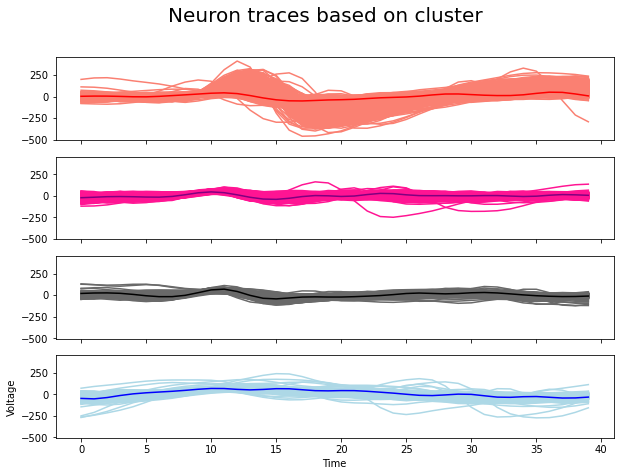

Last clusters


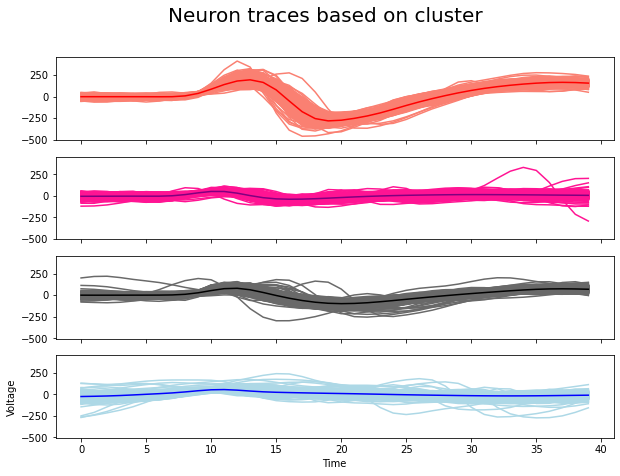

In [16]:
print("First clusters")
plot_traces_4(xns, rnks_1[0], rnks_1[1], rnks_1[2], rnks[3], mks_init)

print("Last clusters")
plot_traces_4(xns, rnks[0], rnks[1], rnks[2], rnks[3], mks)

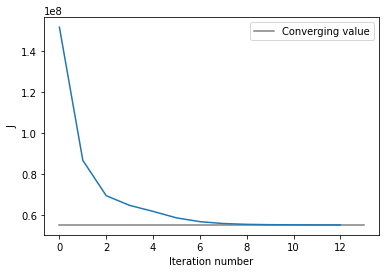

In [17]:
max_ind = len(J)
plt.plot([0,max_ind], [J[max_ind-1], J[max_ind-1]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

In [18]:
# Code for finding when the convergence occurs
# We will define convergence as the value when the difference between 2 iterations is less than 0.001
# of the last iteration value

converging_values = np.zeros(20)

xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Running the simulation 20 times,
for simulation_i in range(20):
    # Initializes with 4 random traces from the dataset
    mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
    J = []
    i = 0
    converging = False

    J1, rnks_1, mks = one_iteration_4(xns, mks_init) # First iteration
    J.append(J1)
    
    while converging == False:
        J1, rnks, mks = one_iteration_4(xns, mks)    
        J.append(J1)
        
        if np.abs(J[i-1]-J[i])< 0.001*J[i]: # Finding the convergence value
            converging_values[simulation_i] = i
            converging = True
        i+=1
        
print(converging_values)
print(np.mean(converging_values))

[14.  7.  5.  3.  9. 17.  6. 20.  7.  9.  4.  8.  8.  7.  8.  8. 13. 11.
 10.  6.]
9.0


Notice how it takes more iterations of the K-means algorithm to converge when using a bigger amount of clusters. In general, the mean is around 8 iterations to reach the condition when we said the cost function changed very little.

Another way in which we would see the need to stop iterating would be when the assignments don't change anymore. Unless there was a periodic function.

Some websites consulted for this part of the homework:

- https://en.wikipedia.org/wiki/K-means_clustering

- https://quick-adviser.com/how-do-you-implement-k-means/

# Part 4
## Using Gaussian mixtures

In [19]:
SpikeWaveforms = np.load('SpikeWaveforms12.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))

(16789, 40, 4)


In [20]:
indices = []
Peaks_1 = []
Peaks_2 = []
Peaks_3 = []
Peaks_4 = []
xn_ex2 = []

# Indices for starting and ending
start = 5
end = 25

for i in range(16789): #16789
    
    average_tetrodes = np.zeros(40)

    for time_i in range(40):
        average_tetrodes[time_i] = (np.sum(SpikeWaveforms[i,time_i,0]+SpikeWaveforms[i,time_i,1]+SpikeWaveforms[i,time_i,2]+SpikeWaveforms[i,time_i,3]))/4
        
    index = np.argmax(average_tetrodes[start:end])
    
    Peaks_1.append(SpikeWaveforms[i, index, 0])
    Peaks_2.append(SpikeWaveforms[i, index, 1])
    Peaks_3.append(SpikeWaveforms[i, index, 2])
    Peaks_4.append(SpikeWaveforms[i, index, 3])
    xn_ex2.append(SpikeWaveforms[i, :, 0])

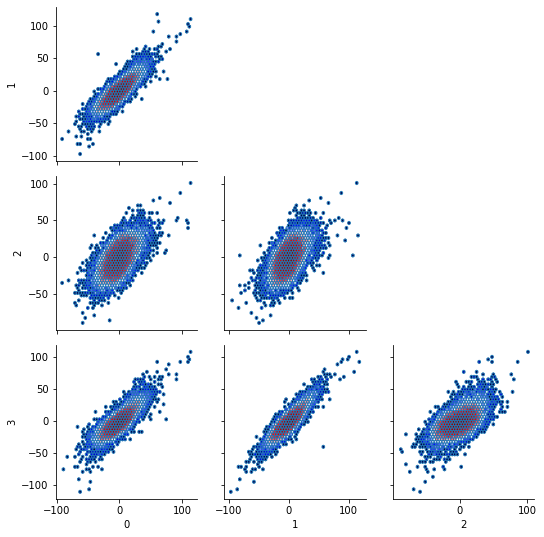

In [21]:
Peaks = [Peaks_1, Peaks_2, Peaks_3, Peaks_4]
Peaks = np.transpose(Peaks)

# Code from class website
PP = pd.DataFrame(np.array(Peaks))
g = sns.PairGrid(PP)
g = g.map_lower(plt.hexbin,gridsize=50, mincnt=1, cmap='seismic',bins='log')
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

### Part a
Learn the Gaussian mixture parameters for K=10 neurons. Plot the resulting cluster assignments in a six panel plot as in (2) with the clusters color-coded. A well documented example can be found in from the scikit-learn docs.

Only use the peak values, not the whole time series.

In [22]:
# Code from homework assignment
gmix = mixture.GaussianMixture(n_components=10, covariance_type='full')
gmix.fit(Peaks)
np.shape(Peaks)

training = Peaks[:5000,:]
classification = gmix.fit(training).predict(training) +1 # You are assinging to each component one class from 1 to 10

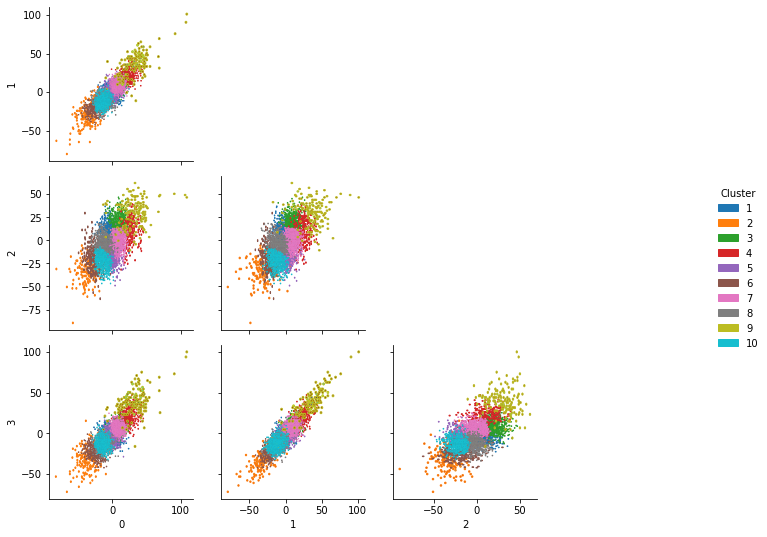

In [23]:
# Plot with cluster labels legend
PP = pd.DataFrame(np.array(training))
PP["Cluster"] = classification.tolist()
g = sns.PairGrid(PP, hue = "Cluster")
g = g.map_lower(plt.hexbin, gridsize=50, mincnt=1, cmap='jet_r',bins='log')

for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
g.add_legend()
plt.show()

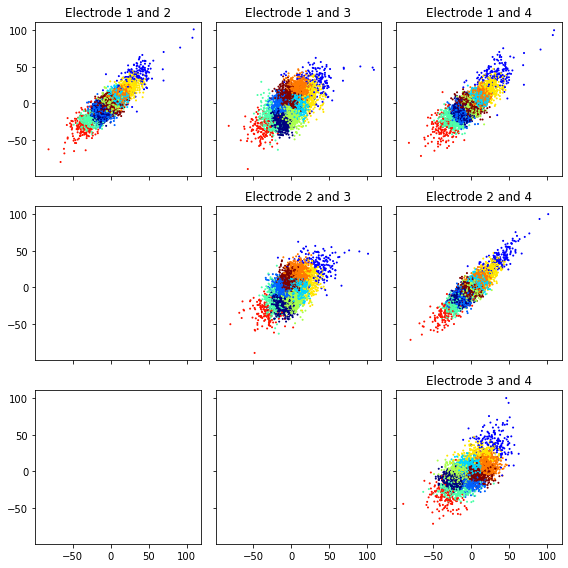

In [24]:
# Plot K=10 without cluster labels
fig, axs = plt.subplots(3, 3, figsize=(8,8), sharex=True, sharey=True)

axs[0, 0].scatter(training[:, 0], training[:, 1], c = classification, cmap="jet_r", s=1)
axs[0, 0].set_title("Electrode 1 and 2")

axs[0, 1].scatter(training[:, 0], training[:, 2], c = classification, cmap="jet_r", s=1)
axs[0, 1].set_title("Electrode 1 and 3")

axs[0, 2].scatter(training[:, 0], training[:, 3], c = classification, cmap="jet_r", s=1)
axs[0, 2].set_title("Electrode 1 and 4")

axs[1, 1].scatter(training[:, 1], training[:, 2], c = classification, cmap="jet_r", s=1)
axs[1, 1].set_title("Electrode 2 and 3")

axs[1, 2].scatter(training[:, 1], training[:, 3], c = classification, cmap="jet_r", s=1)
axs[1, 2].set_title("Electrode 2 and 4")

axs[2, 2].scatter(training[:, 2], training[:, 3], c = classification, cmap="jet_r", s=1)
axs[2, 2].set_title("Electrode 3 and 4")

plt.tight_layout()
plt.show()

### Part b.
Find the cluster assignments for the next 5000 snippet-peaks. You will use these as test data to evaluate how many clusters there should be in the data. Calculate the model likelihood of the second set of 5000 snippet-peaks using the parameters you found in (a). The score_samples() function returns the log likelihood of one or more data points. The score() function returns the average log likelihood for many data points, which represents the model quality we care about. Now, repeat the EM-learning in (a), but with K=8,9,…,20. What is the likelihood of the test data for each model? Which model would you use if you wanted only well-clustered neurons for your analysis? For the most likely value of K, plot the cluster assignments as in (a).

In [25]:
training = Peaks[:5000,:]
test = Peaks[5000:10000,:]

ks = [i+8 for i in range(13)]
scores = np.zeros(len(ks))
classifications = []

for i in range(len(ks)):
    gmix = mixture.GaussianMixture(n_components=ks[i], covariance_type='full')
    classification = gmix.fit(training).predict(test) +1 # You are assinging to each component one class
    classifications.append(classification)
    scores[i] = gmix.fit(training).score(test) # Likelihood of the test data
    
# K value that maximizes the likelihood
best_k_value = np.argmax(scores)+8
print("Number of clusters (K) that maximizes the likelihood: ",best_k_value)

Number of clusters (K) that maximizes the likelihood:  10


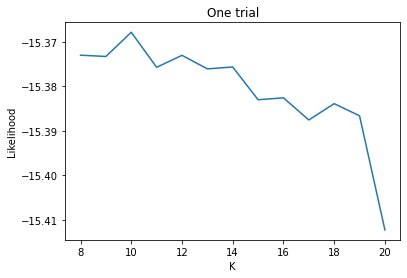

In [26]:
plt.plot(ks, scores)
plt.xlabel("K")
plt.ylabel("Likelihood")
plt.title("One trial")
plt.show()

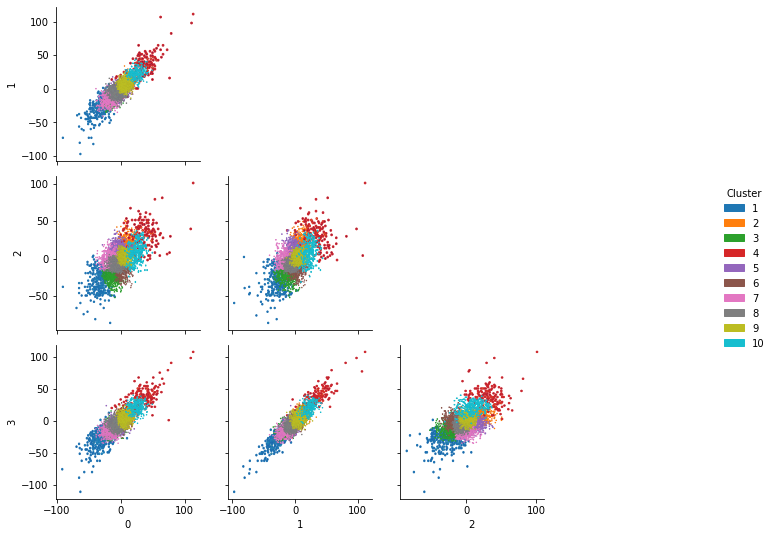

In [27]:
# Plot with cluster labels legend
PP = pd.DataFrame(np.array(test))
PP["Cluster"] = classifications[best_k_value-8].tolist()
g = sns.PairGrid(PP, hue = "Cluster")
g = g.map_lower(plt.hexbin, gridsize=50, mincnt=1, cmap='jet',bins='log')

for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)
g.add_legend()
plt.show()

If instead of using a fixed dataset, we shuffled the data and obtained the average likelihood for a certain number of trials, this would give us an average trend. This idea is implemented in the following cells. The motivation behind is that the K value that maximizes the likelihood changes from one trial to another.

In [28]:
ks = [i+8 for i in range(13)]
scores = np.zeros(len(ks))
repetitions = 20

for i in range(len(ks)):
    for same_k_i in range(repetitions):
        # In each iteration, data will be shuffled again
        shuffled_data = shuffle(Peaks)
        training = shuffled_data[:5000,:]
        test = shuffled_data[5000:10000,:]

        gmix = mixture.GaussianMixture(n_components=ks[i], covariance_type='full')
        scores[i] += gmix.fit(training).score(test) # Likelihood of the test data

scores = scores/repetitions

best_averaged_k_value = np.round(np.argmax(scores)+8)
print("K value that maximizes the likelihood:",best_averaged_k_value)    

K value that maximizes the likelihood: 8


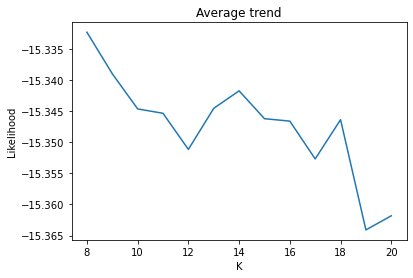

In [29]:
plt.plot(ks, scores)
plt.xlabel("K")
plt.ylabel("Likelihood")
plt.title("Average trend")
plt.show()

The number of clusters we should use corresponds to the value that maximizes the likelihood (value closer to 0). Because this would give us the best K value for predicting the cluster value for a new datapoint. So we should use around 10 clusters. But this value changes in each trial, even when using an average value of several trials.

If we only wanted well-clustered neurons for the analysis, we could try to use the largest within reasonable K value. The problem of doing this is that the covariance matrix would be bigger and a larger amount of operations would have to be computed in each iteration.

### Part 4c
Train models with a full covariance matrix as in (a) and a diagonal covariance matrix (use the covariance_type='diagonal' option). Compare the model likelihoods on test data. Which model does a better job?

Because fo good practices, we will shuffle the data.

In [30]:
shuffled_data = shuffle(Peaks)

training = shuffled_data[:5000,:]
test = shuffled_data[5000:,:] # Test data is everything, not only 5000 data points

ks = [i+8 for i in range(13)]
scores_full = np.zeros(len(ks))
scores_diag = np.zeros(len(ks))

for i in range(len(ks)):
    gmix_full = mixture.GaussianMixture(n_components=ks[i], covariance_type='full')
    gmix_diag = mixture.GaussianMixture(n_components=ks[i], covariance_type='diag')    
       
    scores_full[i] = gmix_full.fit(training).score(test) # Likelihood of the test data
    scores_diag[i] = gmix_diag.fit(training).score(test) # Likelihood of the test data    

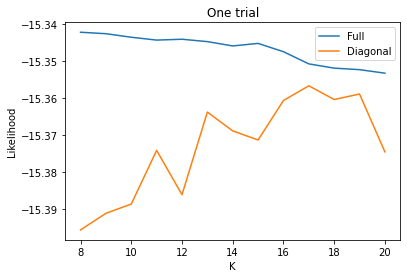

In [31]:
plt.plot(ks, scores_full, label = "Full")
plt.plot(ks, scores_diag, label = "Diagonal")
plt.xlabel("K")
plt.ylabel("Likelihood")
plt.title("One trial")
plt.legend()
plt.show()

Analogue to the previous exercise, we will run several trials and find an average trend.

In [32]:
ks = [i+8 for i in range(13)]
scores_full = np.zeros(len(ks))
scores_diag = np.zeros(len(ks))
repetitions = 10
    
for i in range(len(ks)):
    for same_k_i in range(repetitions):
        # In each iteration, data will be shuffled again
        shuffled_data = shuffle(Peaks)
        training = shuffled_data[:5000,:]
        test = shuffled_data[5000:10000,:]

        gmix_full = mixture.GaussianMixture(n_components=ks[i], covariance_type='full')
        gmix_diag = mixture.GaussianMixture(n_components=ks[i], covariance_type='diag')    
       
        scores_full[i] += gmix_full.fit(training).score(test) # Likelihood of the test data
        scores_diag[i] += gmix_diag.fit(training).score(test) # Likelihood of the test data    

scores_full = scores_full/repetitions
scores_diag = scores_diag/repetitions

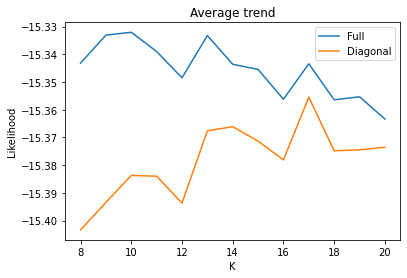

In [33]:
plt.plot(ks, scores_full, label = "Full")
plt.plot(ks, scores_diag, label = "Diagonal")
plt.xlabel("K")
plt.ylabel("Likelihood")
plt.title("Average trend")
plt.legend()
plt.show()

Notice how the maximum values for the likelihood correspond to the Full ``covariance_type``. 

As we saw in class, depending on your parameters is what kind of covariance matrix you should use. For example, a diagonal matrix is useful when considering uncorrelated datapoints. A full covariance matrix is useful when the covariance is tipped to one side.

In this particular case, it makes most sense to use a full coviariance matrix because there is a relation between data points. They are not independent.

A drawback of using a full covariance matrix is that it makes the process slower.

# Part 5
## Clustering using Pearson Correlation

This problem replicates a result from the paper “Sub-second dynamics of theta-gamma coupling in hippocampal CA1” by Zhang et al https://elifesciences.org/articles/44320. They calculated the spectrograms of their LFP data and extracted individual theta cycles. They then clustered these spectrograms to assess whether higher frequency gamma oscillations preferentially occur at certain phases of theta.

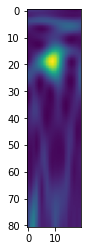

In [34]:
data = np.load('hw4problem5.npy')
plt.imshow(data[0,:,:])
plt.show()

In [35]:
print(np.shape(data))
phase = np.linspace(-np.pi, np.pi, 20) # phase
freqs = np.arange(20, 182, 2)[::-1] # frequency vector
# in the frequency vector and the data, the 0-th entry corresponds to the highest frequency (180 Hz)

(3900, 81, 20)


In [36]:
# Normalizing data across samples
flat = np.reshape(data,(3900,1620))

mean_x = np.mean(flat,1)
stdev = np.std(flat,1)
print(mean_x.shape)

normdata = np.zeros(data.shape)

for i in range(len(mean_x)):
    normdata[i] = (data[i] - mean_x[i])/stdev[i]
print(normdata.shape)

(3900,)
(3900, 81, 20)


## Part a
Cluster the theta cycle spectrograms into K=4 clusters. Plot the mean spectrogram of each cluster as in their Figure 1D.

In [37]:
# Extract of code from HW problem
K = 4
ndata = np.reshape(normdata, (normdata.shape[0], normdata.shape[1] * normdata.shape[2]))
kmeans = KMeans(n_clusters=K, random_state=0, algorithm="full").fit(ndata)

cluster0 = np.reshape(kmeans.cluster_centers_[0,:], (normdata.shape[1], normdata.shape[2]))
cluster1 = np.reshape(kmeans.cluster_centers_[1,:], (normdata.shape[1], normdata.shape[2]))
cluster2 = np.reshape(kmeans.cluster_centers_[2,:], (normdata.shape[1], normdata.shape[2]))
cluster3 = np.reshape(kmeans.cluster_centers_[3,:], (normdata.shape[1], normdata.shape[2]))

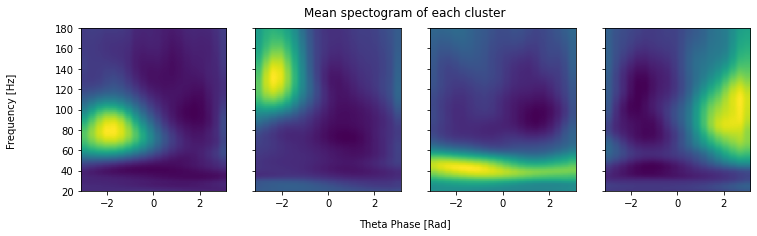

In [38]:
# Replicating figure 1D
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12,3))

ax1.imshow(cluster0, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax2.imshow(cluster1, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax3.imshow(cluster2, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax4.imshow(cluster3, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')

fig.text(0.5, -0.04, 'Theta Phase [Rad]', ha='center')
fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
plt.suptitle("Mean spectogram of each cluster")
plt.show()

### Part b
Find 3 data points (i.e., theta cycles) which are close to the centroid of each cluster and plot them. How similar do invidivual cycles look to the averages?

In [39]:
normalized_data = normdata
iterations = len(normalized_data)
distances0 = np.zeros(iterations)
distances1 = np.zeros(iterations)
distances2 = np.zeros(iterations)
distances3 = np.zeros(iterations)

for i in range(iterations):
    # Finding the distance from every normalized_data to cluster center
    distances0[i] = np.sum(np.abs(cluster0 - normalized_data[i,:,:]))
    distances1[i] = np.sum(np.abs(cluster1 - normalized_data[i,:,:]))
    distances2[i] = np.sum(np.abs(cluster2 - normalized_data[i,:,:]))
    distances3[i] = np.sum(np.abs(cluster3 - normalized_data[i,:,:]))

# Sorting the distances for every cluster and finding the 3 minimum values
minimum_indices0 = distances0.argsort()[0:3]
minimum_indices1 = distances1.argsort()[0:3]
minimum_indices2 = distances2.argsort()[0:3]
minimum_indices3 = distances3.argsort()[0:3]
print (minimum_indices0)

[1431 1710 3635]


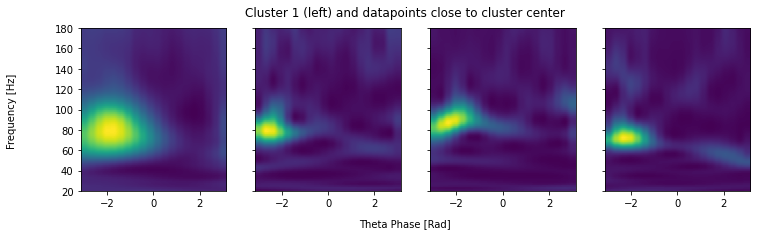

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12,3))

ax1.imshow(cluster0, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax2.imshow(normalized_data[minimum_indices0[0]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax3.imshow(normalized_data[minimum_indices0[1]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax4.imshow(normalized_data[minimum_indices0[2]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')

fig.text(0.5, -0.04, 'Theta Phase [Rad]', ha='center')
fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
plt.suptitle("Cluster 1 (left) and datapoints close to cluster center")
plt.show()

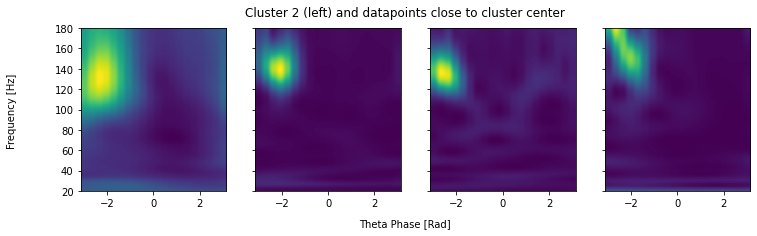

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12,3))

ax1.imshow(cluster1, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax2.imshow(normalized_data[minimum_indices1[0]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax3.imshow(normalized_data[minimum_indices1[1]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax4.imshow(normalized_data[minimum_indices1[2]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')

fig.text(0.5, -0.04, 'Theta Phase [Rad]', ha='center')
fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
plt.suptitle("Cluster 2 (left) and datapoints close to cluster center")
plt.show()

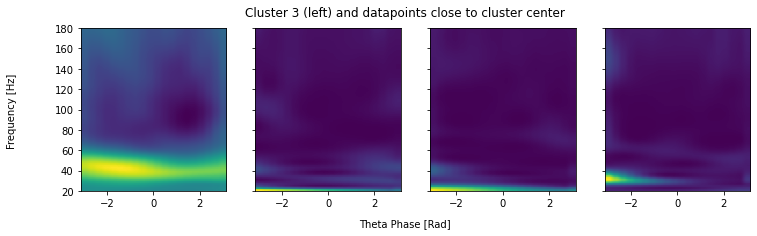

In [42]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12,3))

ax1.imshow(cluster2, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax2.imshow(normalized_data[minimum_indices2[0]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax3.imshow(normalized_data[minimum_indices2[1]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax4.imshow(normalized_data[minimum_indices2[2]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')

fig.text(0.5, -0.04, 'Theta Phase [Rad]', ha='center')
fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
plt.suptitle("Cluster 3 (left) and datapoints close to cluster center")
plt.show()

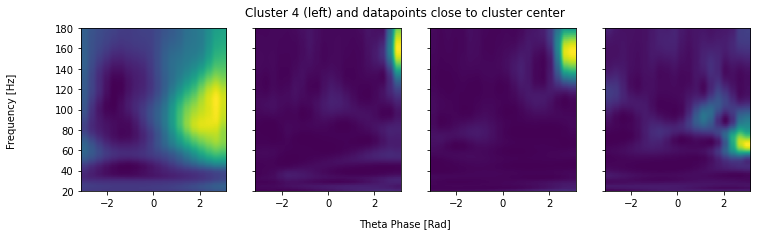

In [43]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12,3))

ax1.imshow(cluster3, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax2.imshow(normalized_data[minimum_indices3[0]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax3.imshow(normalized_data[minimum_indices3[1]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
ax4.imshow(normalized_data[minimum_indices3[2]], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')

fig.text(0.5, -0.04, 'Theta Phase [Rad]', ha='center')
fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
plt.suptitle("Cluster 4 (left) and datapoints close to cluster center")
plt.show()

Qualitatively, the individual datapoints look similar to their cluster in the sense that they have, on average, light and dark regions in similar places of the plot. Quantitatively, these datapoints have the least distance to that particular cluster. So on overage, each point has a similar value as that corresponding point in the cluster.

### Part c
Find 3 data points which are close to the boundaries of two or more of the different clusters. (You can do this by finding the distances to each cluster center, and sorting the data points by how close they are!) Plot these examples. Give a qualitative description.

The data point that are close to the boundaries have a bigger distance from the cluster centers to these points. So the outlier points can be found suming these distances and obtaining the maximum values.

In [44]:
# Obtaining the distance from each data point to the cluster centers
sum_distances = distances0 + distances1 + distances2 + distances3

# Sorting the datapoints and ordering them from maximum distance to lowest distance,
min_to_max = sum_distances.argsort()
index = [min_to_max[len(min_to_max)-i-1] for i in range(len(min_to_max))]

Note there is a flaw in the previous thinking process. What if a point is on the boundary of two clusters, but is very near the cluster center of another one? For not running into this problem, we will impose the condition of finding points that are outliers of all 4 clusters by a normalized distance condition: 

In [45]:
# Choosing the datapoints that maximize the distance to alle the cluster centers
maximum_indices = []
i = 0

for i in range(len(index)):
    condition_c0 = (np.abs(max(distances0)) - distances0[index[i]])/max(distances0)
    condition_c1 = (np.abs(max(distances1)) - distances1[index[i]])/max(distances1)
    condition_c2 = (np.abs(max(distances2)) - distances2[index[i]])/max(distances2)
    condition_c3 = (np.abs(max(distances3)) - distances3[index[i]])/max(distances3)
    
    # Outlier points have at least a normalized distance 20% away form cluster center
    if condition_c0 < 0.2 and condition_c1 < 0.2 and condition_c2 < 0.2 and condition_c3 < 0.2:
        maximum_indices.append(index[i])

    if len(np.array(maximum_indices)) ==3: # 3 times the condition is met
        break
        
print(maximum_indices)

[3705, 2896, 2092]


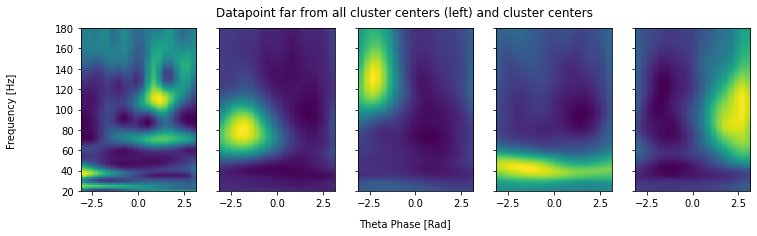

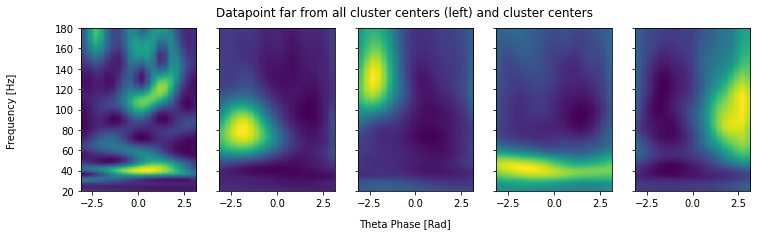

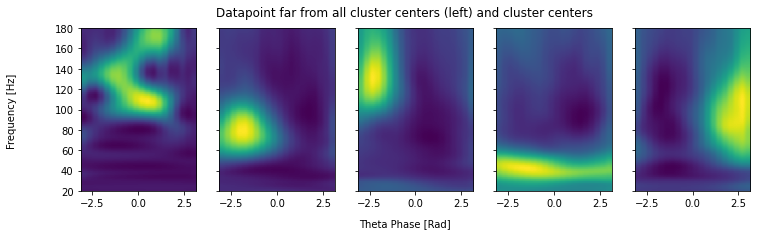

In [46]:
for index in maximum_indices:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(12,3))

    ax1.imshow(normalized_data[index], extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
    ax2.imshow(cluster0, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
    ax3.imshow(cluster1, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
    ax4.imshow(cluster2, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')
    ax5.imshow(cluster3, extent = [-np.pi , np.pi, 20 , 180], origin='lower', aspect='auto')

    fig.text(0.5, -0.04, 'Theta Phase [Rad]', ha='center')
    fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')
    plt.suptitle("Datapoint far from all cluster centers (left) and cluster centers")
    plt.show()

From looking at these pictures, we could say that the yellow areas of the outlier data points (left) do not seem to fit in the yellow areas of the cluster centers. And even if they do a little, this contribution would probably be cancelled when considering the rest of the region.

Basically, the contribution is not only of the yellow areas, but the darker areas also contribute.